Importing All Important Libraries and Packages

In [ ]:
import numpy as np
import pandas as pd
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.ensemble as ske
import sklearn.neural_network as sknn
import sklearn.pipeline as skp
import sklearn.tree as skt
import sklearn.preprocessing as skpp
import matplotlib.pyplot as plt
from typing import List
from math import sqrt



## Data Pre-Process Phase
**Clean and Prepare data for regression model consumption**

1. Set measurement as data frame index.
2. Drop rows that contain null values.
3. Select a sample measurement statation.
4. Create a column with shifted values (results) to compare predictions. This column will help to compare expected vs real values.

In [ ]:
def init_daily_data(station: str="09N03E08C003M") -> pd.DataFrame:
    daily_data_by_sample_station: pd.DataFrame = pd.read_csv('gwl-daily.csv')
    daily_data_by_sample_station["MSMT_DATE"] = pd.to_datetime(daily_data_by_sample_station["MSMT_DATE"])
    daily_data_by_sample_station = daily_data_by_sample_station.loc[
        daily_data_by_sample_station["WSE"].notnull(),
        ["STATION", "MSMT_DATE", "WLM_RPE", "WLM_RPE_QC", "WLM_GSE", "WLM_GSE_QC", "RPE_WSE", "RPE_WSE_QC", "GSE_WSE", "GSE_WSE_QC", "WSE", "WSE_QC"]]
    daily_data_by_sample_station = daily_data_by_sample_station.loc[
        daily_data_by_sample_station["WLM_GSE"].notnull(),
        ["STATION", "MSMT_DATE", "WLM_RPE", "WLM_RPE_QC", "WLM_GSE", "WLM_GSE_QC", "RPE_WSE", "RPE_WSE_QC", "GSE_WSE", "GSE_WSE_QC", "WSE", "WSE_QC"]]

    # Select Sample Station
    daily_data_by_sample_station = daily_data_by_sample_station[daily_data_by_sample_station["STATION"] == station]
    daily_data_by_sample_station = daily_data_by_sample_station.set_index("MSMT_DATE").sort_index()

    daily_data_by_sample_station["target"] = daily_data_by_sample_station.shift(-1)["GSE_WSE"]
    daily_data_by_sample_station = daily_data_by_sample_station.iloc[:-1, :].copy()

    return daily_data_by_sample_station

daily_data_by_sample_station = init_daily_data()

In [ ]:
predictors: List[str] = ["WLM_RPE", "WLM_GSE", "RPE_WSE", "GSE_WSE", "WSE"]
models_without_coef: tuple = (skp.Pipeline, ske._forest.RandomForestRegressor, sklm._ransac.RANSACRegressor, ske._bagging.BaggingRegressor,
                              sknn._multilayer_perceptron.MLPRegressor, skt._classes.DecisionTreeRegressor, ske._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor,
                             ske._gb.GradientBoostingRegressor, ske._voting.VotingRegressor)

### Create Linear Regression Function
1. Create training and testing data frames.
2. Fit the model using a predictors set (X value) and target measurement training set (y value).
3. Create a new data frame with the predictions and expected (real) values.
4. Print and plot Model's performance.

In [ ]:
def predict_linear_regressors(dataframe: pd.DataFrame, model: sklm, predictors: List[str]=["WLM_RPE", "WLM_GSE", "RPE_WSE", "GSE_WSE", "WSE"]) -> pd.DataFrame:
    dataframes: List[pd.DataFrame] = dataframe_training_testing_subsets(dataframe)
    train: pd.DataFrame = dataframes[0]
    test: pd.DataFrame = dataframes[1]

    model.fit(train[predictors], train["target"])
    predictions: [] = model.predict(test[predictors])

    combined: pd.DataFrame = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["actual", "predictions"]

    if not (isinstance(model, models_without_coef)):
        feature_statistics(model)
        print("Independent term: %.3f" %model.intercept_)

    model_metrics(test["target"], predictions)
    combined.plot(figsize=(25,10), fontsize=15)

    return combined

### Create Training and Testing Data frames Function
1. Based on a given data frame, create separate training and test data frame.
2. Each subsequent data frame can have a start date given as function parameter.
3. The function returns a list of data frames (Training, Test).

In [ ]:
# Check if MSMT_DATE is a column, and if so, set it as the index
if 'MSMT_DATE' in daily_data_by_sample_station.columns:
    daily_data_by_sample_station.set_index('MSMT_DATE', inplace=True)
else:
    print("'MSMT_DATE' column not found")



In [ ]:
def dataframe_training_testing_subsets(dataframe: pd.DataFrame, train_date: str="2021-12-31", test_date: str="2022-1-1") -> List[pd.DataFrame]:
    res: List[pd.DataFrame] = []
    train: pd.DataFrame = dataframe.loc[:train_date]
    test: pd.DataFrame = dataframe.sort_index().loc[test_date:]
    res.extend([train, test])

    return res

### Feature statistics model
1. For each model's feature, print its coefficient statistic.

In [ ]:
def feature_statistics(model: sklm) -> None:
    items = []
    coef: np.ndarray = model.coef_
    for index, item in enumerate(model.feature_names_in_):
        print(f"{item} - Coeficcient: {coef[index]}")
    print("\n")

### Model Metrics
1. Print model performance statistics

In [ ]:
def model_metrics(target: pd.DataFrame, predictions: []) -> None:
    print("Explained variance regression score: %.3f" %skm.explained_variance_score(target, predictions))
    print("Maximum residual error: %.3f" %skm.max_error(target, predictions))
    print("Mean squared error: %.3f" %skm.mean_squared_error(target, predictions))
    print("Coeficcient of determination: %.3f" %skm.r2_score(target, predictions))
    print("Root-mean-square error: %.3f" %sqrt(skm.mean_squared_error(target, predictions)))

# Classical Linear Regressors
1. Linear Regresion (Ordinary least squares Linear Regression).
2. Ridge (Linear least squares with I2 regularization.
3. Ridge CV (Ridge regression with built-in cross-validation).


## Linear Regression
**Ordinary least squares Linear Regression.**

LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

WLM_RPE - Coeficcient: 8.011840547938313e-19
WLM_GSE - Coeficcient: 181.1220588405804
RPE_WSE - Coeficcient: -278.8587390740397
GSE_WSE - Coeficcient: -180.10555375415635
WSE - Coeficcient: -459.96229044756853


Independent term: 8417.138
Explained variance regression score: 0.991
Maximum residual error: 7.382
Mean squared error: 2.150
Coeficcient of determination: 0.991
Root-mean-square deviation: 1.466


,actual,predictions
MSMT_DATE,,
2022-01-01,18.382,18.308142
2022-01-02,18.244,18.380464
2022-01-03,18.151,18.242741
2022-01-04,18.032,18.149927
2022-01-05,17.894,18.031165
...,...,...
2022-05-27,72.663,75.319222
2022-05-28,71.726,72.552773
2022-05-29,70.673,71.617649


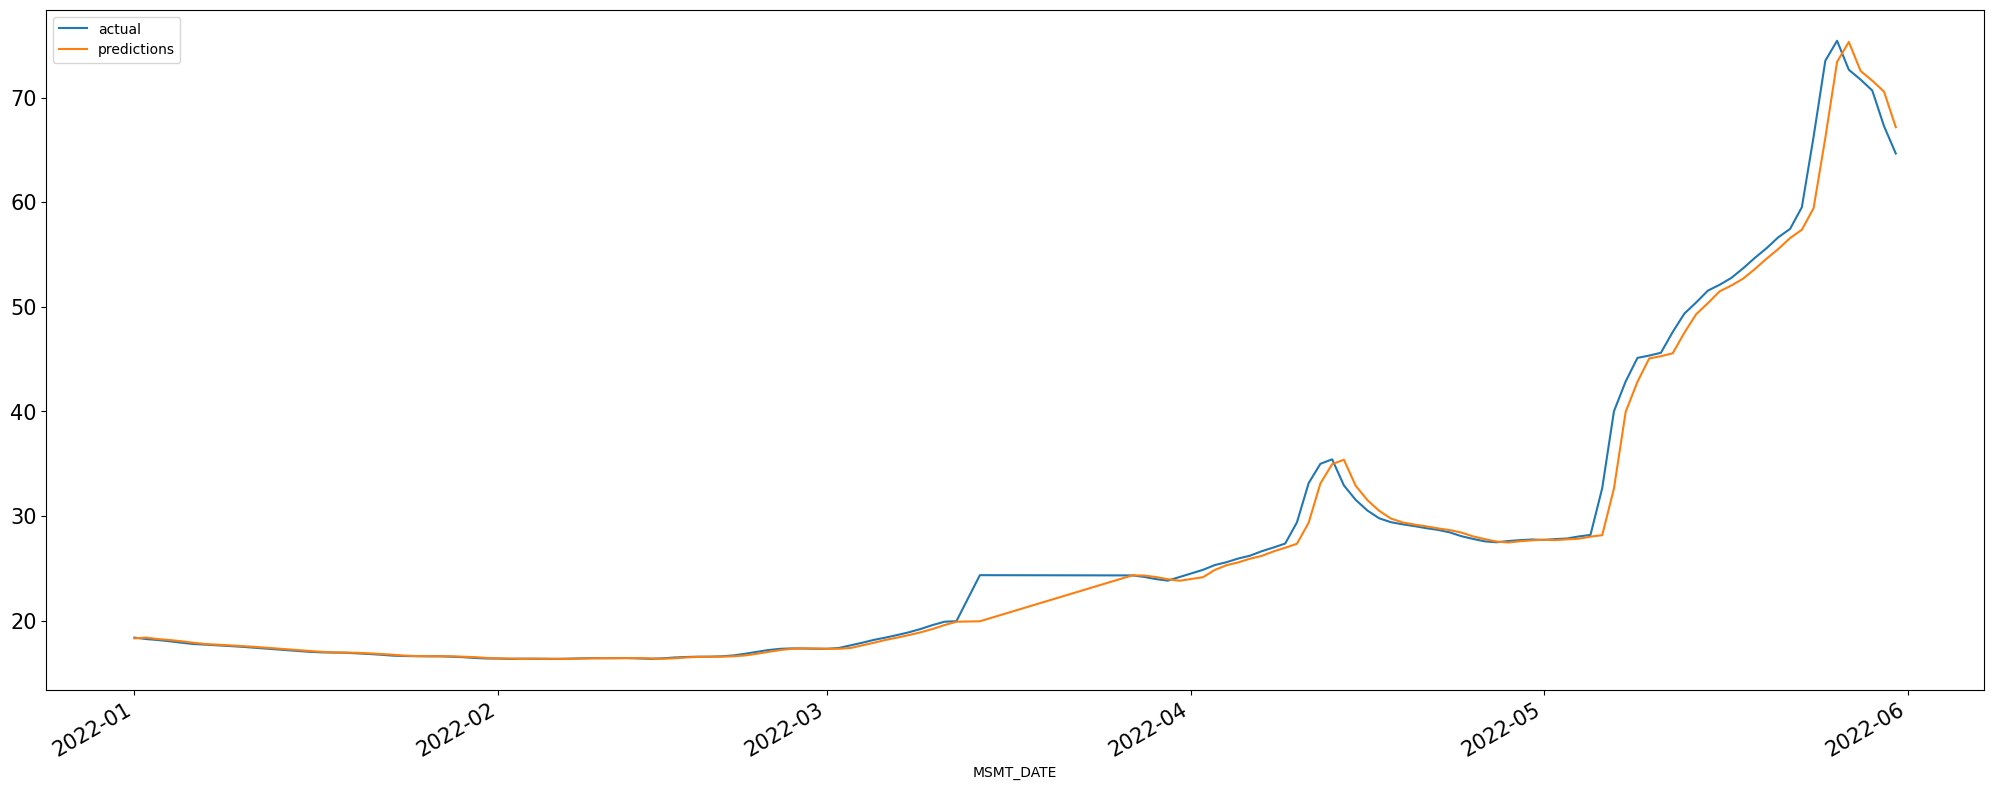

In [ ]:
linear_reg = sklm.LinearRegression()
predict_linear_regressors(daily_data_by_sample_station, linear_reg)

## Ridge
**Linear least squares with l2 regularization.**

Minimizes the objective function:
> ||y - Xw||^2_2 + alpha * ||w||^2_2

This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. Also known as Ridge Regression or Tikhonov regularization. This estimator has built-in support for multi-variate regression (i.e., when y is a 2d-array of shape (n_samples, n_targets)).

WLM_RPE - Coeficcient: 1.8576338152872408e-25
WLM_GSE - Coeficcient: 0.48764591730644674
RPE_WSE - Coeficcient: 0.22702876265697325
GSE_WSE - Coeficcient: 0.5310047167425158
WSE - Coeficcient: -0.2400827274547987


Independent term: -7.409
Explained variance regression score: 0.991
Maximum residual error: 7.384
Mean squared error: 2.150
Coeficcient of determination: 0.991
Root-mean-square deviation: 1.466


,actual,predictions
MSMT_DATE,,
2022-01-01,18.382,18.485395
2022-01-02,18.244,18.377067
2022-01-03,18.151,18.239327
2022-01-04,18.032,18.146503
2022-01-05,17.894,18.027727
...,...,...
2022-05-27,72.663,75.322591
2022-05-28,71.726,72.555813
2022-05-29,70.673,71.620578


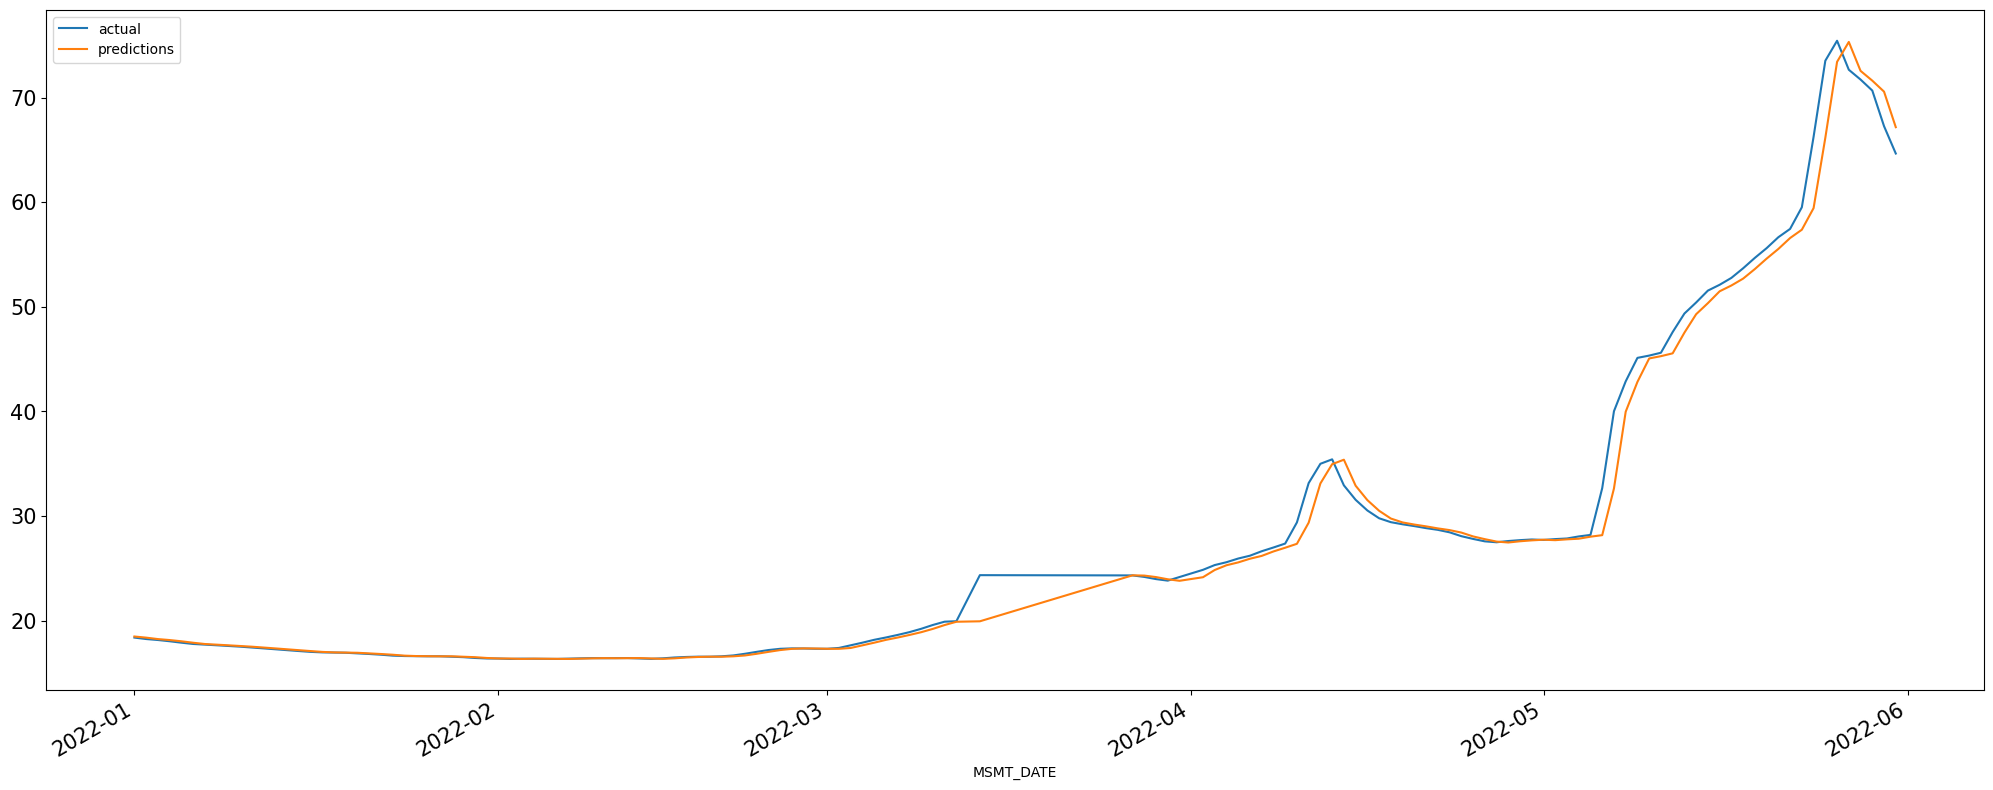

In [ ]:
ridge_reg = sklm.Ridge(alpha=1.0)
predict_linear_regressors(daily_data_by_sample_station, ridge_reg)

## Ridge CV
**Ridge regression with built-in cross-validation.**
By default, it performs efficient Leave-One-Out Cross-Validation.

WLM_RPE - Coeficcient: -4.439310326510175e-22
WLM_GSE - Coeficcient: 54.04839205550148
RPE_WSE - Coeficcient: 20.671369229237005
GSE_WSE - Coeficcient: -53.03006153481064
WSE - Coeficcient: -33.35677532389351


Independent term: -624.532
Explained variance regression score: 0.991
Maximum residual error: 7.384
Mean squared error: 2.151
Coeficcient of determination: 0.991
Root-mean-square deviation: 1.466


,actual,predictions
MSMT_DATE,,
2022-01-01,18.382,18.432328
2022-01-02,18.244,18.377565
2022-01-03,18.151,18.239829
2022-01-04,18.032,18.147008
2022-01-05,17.894,18.028236
...,...,...
2022-05-27,72.663,75.321195
2022-05-28,71.726,72.554509
2022-05-29,70.673,71.619305


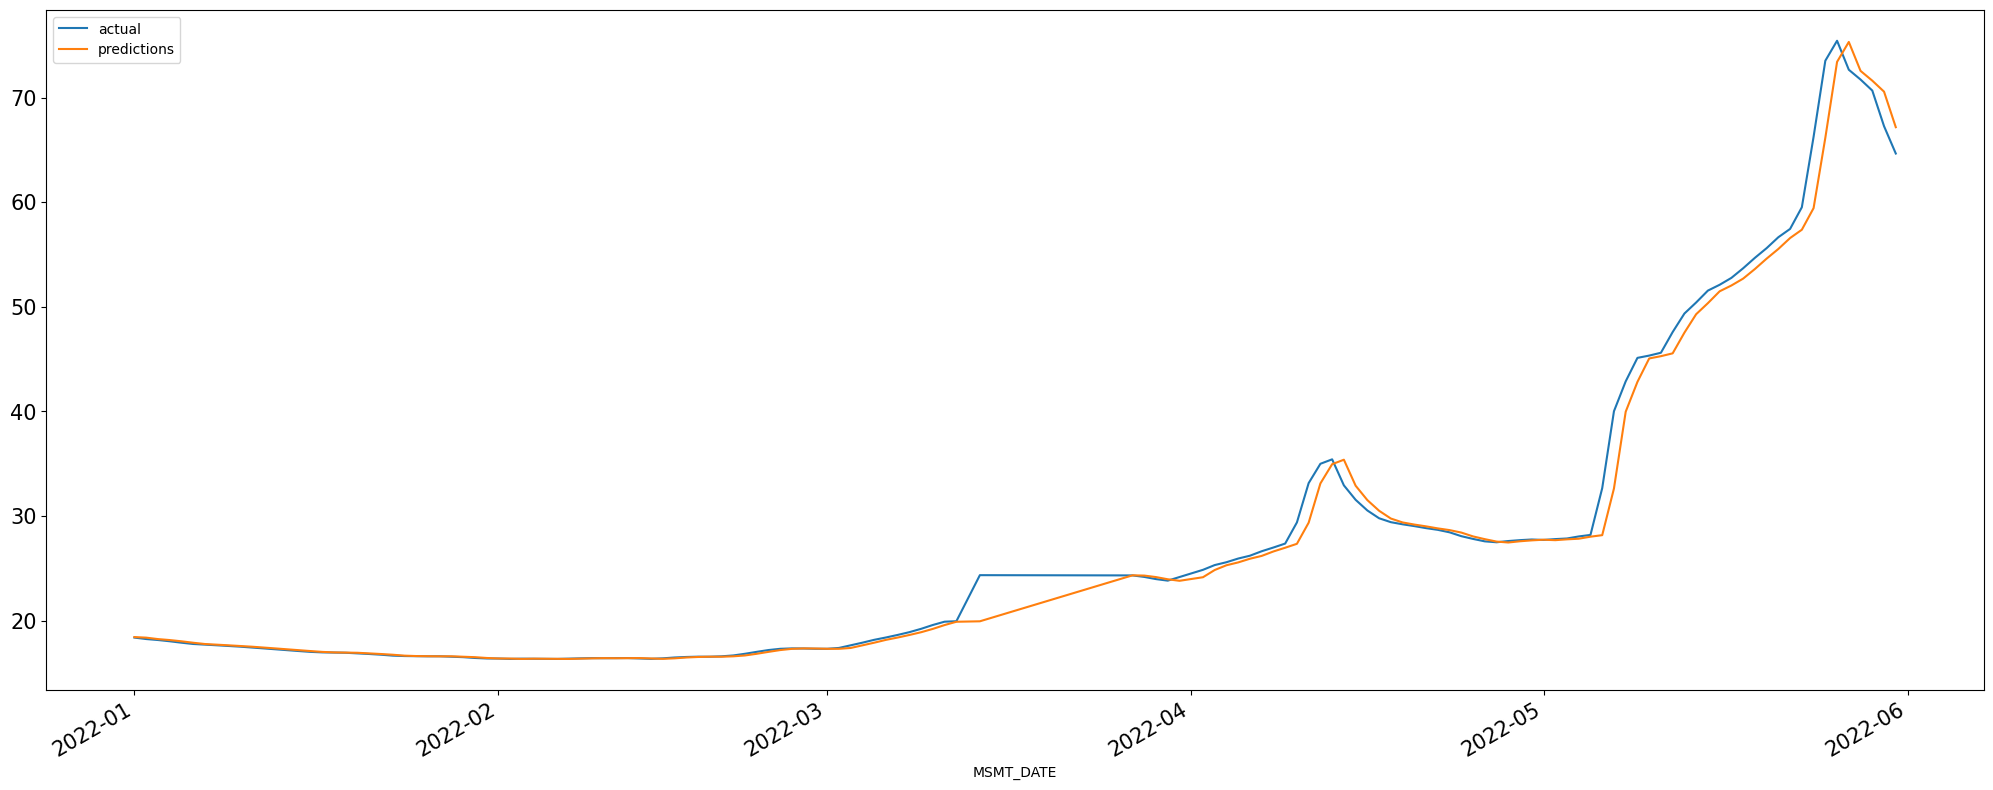

In [ ]:
ridge_cv_reg = sklm.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
predict_linear_regressors(daily_data_by_sample_station, ridge_cv_reg)

# Generalized Linear Models (GLM) for regression
## Poisson regressor
Generalized Linear Model with a Poisson distribution.

This regressor uses the ‘log’ link function.

WLM_RPE - Coeficcient: 1.2949613121600678e-08
WLM_GSE - Coeficcient: 0.018568770746120608
RPE_WSE - Coeficcient: 0.0017685781798123603
GSE_WSE - Coeficcient: 0.02038246411455681
WSE - Coeficcient: -0.0017695902875596381


Independent term: 2.012
Explained variance regression score: 0.914
Maximum residual error: 15.982
Mean squared error: 26.566
Coeficcient of determination: 0.887
Root-mean-square deviation: 5.154


,actual,predictions
MSMT_DATE,,
2022-01-01,18.382,18.841097
2022-01-02,18.244,18.792102
2022-01-03,18.151,18.730171
2022-01-04,18.032,18.688550
2022-01-05,17.894,18.635427
...,...,...
2022-05-27,72.663,73.565821
2022-05-28,71.726,68.846028
2022-05-29,70.673,67.320103


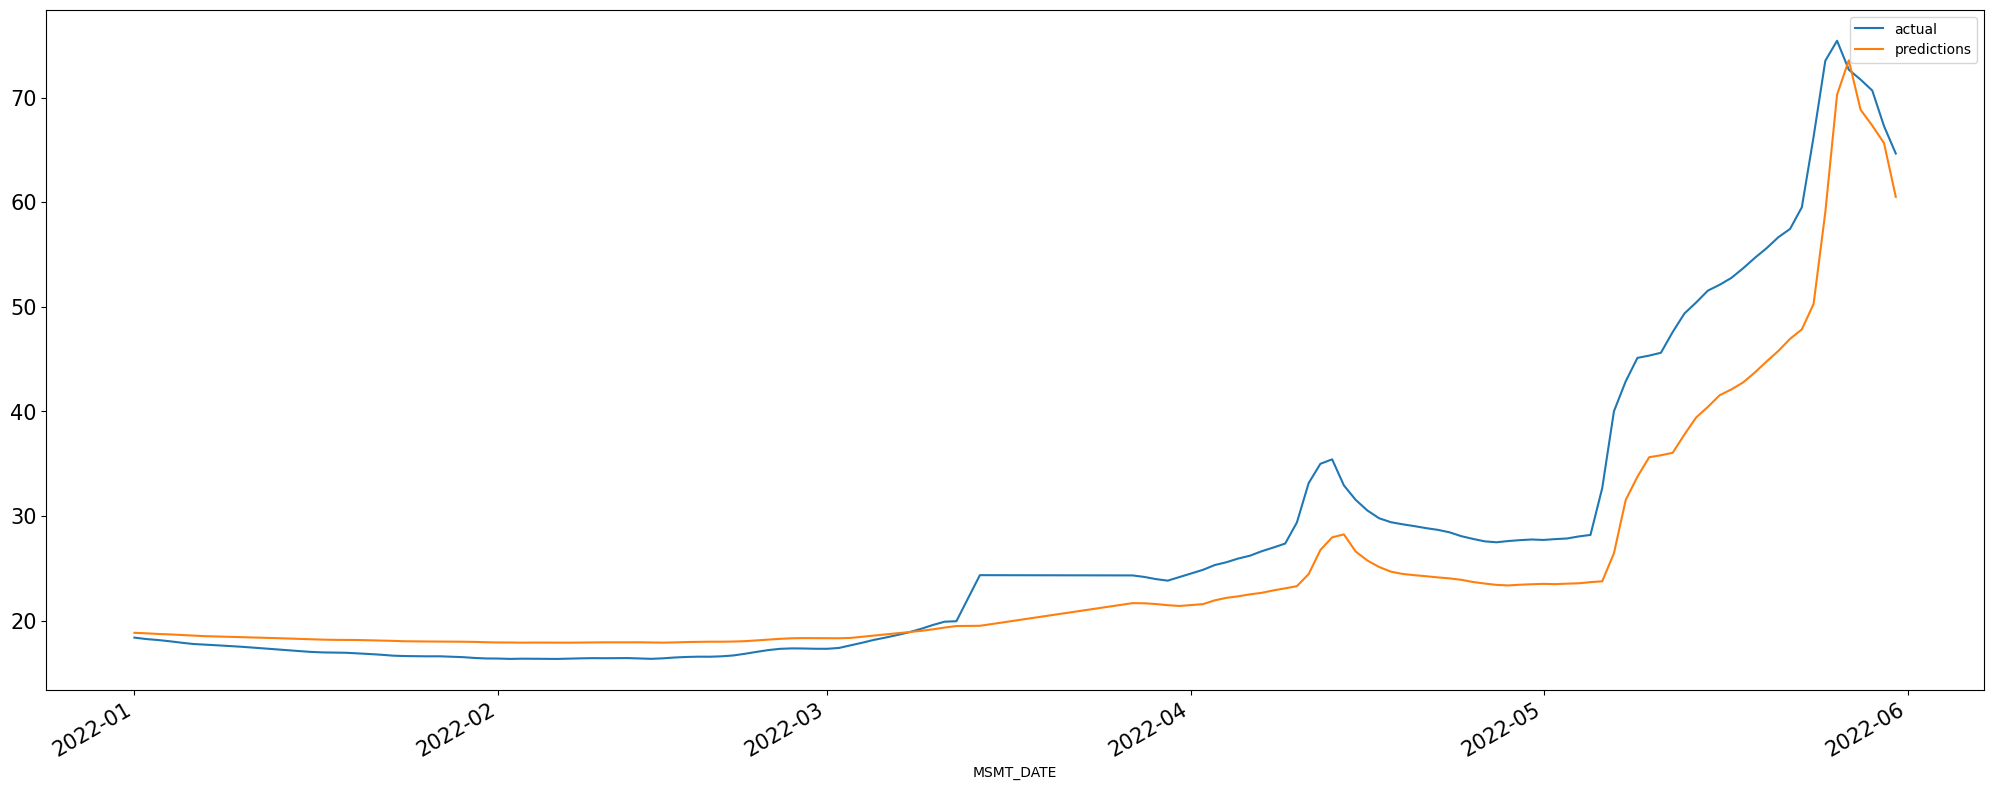

In [ ]:
poisson_reg = sklm.PoissonRegressor()

predict_linear_regressors(daily_data_by_sample_station, poisson_reg)

# Neural Networks
## Multi-layer Perceptron regressor.
Multi-layer Perceptron regressor.

This model optimizes the squared error using LBFGS or stochastic gradient descent.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Explained variance regression score: 0.991
Maximum residual error: 7.000
Mean squared error: 2.083
Coeficcient of determination: 0.991
Root-mean-square deviation: 1.443


,actual,predictions
MSMT_DATE,,
2022-01-01,18.382,19.044437
2022-01-02,18.244,18.941561
2022-01-03,18.151,18.810883
2022-01-04,18.032,18.722817
2022-01-05,17.894,18.610130
...,...,...
2022-05-27,72.663,75.589814
2022-05-28,71.726,72.853577
2022-05-29,70.673,71.928665


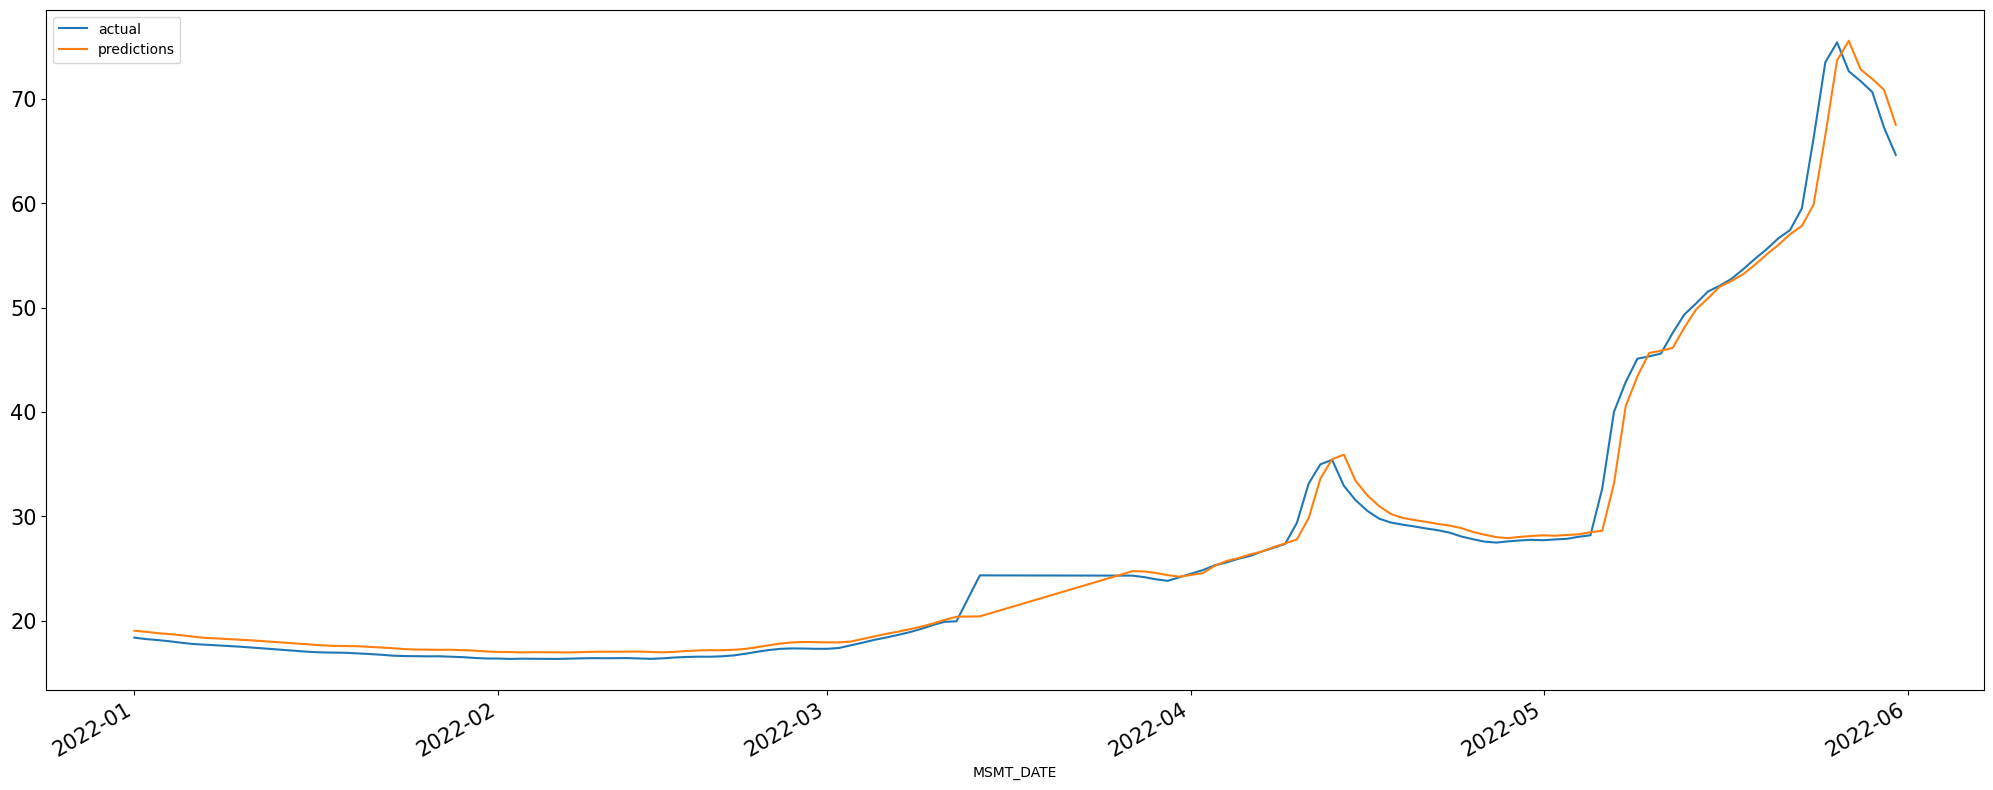

In [ ]:
mlp_reg = sknn.MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=100, random_state=42)

predict_linear_regressors(daily_data_by_sample_station, mlp_reg)

## Bernoulli Restricted Boltzmann Machine (RBM).
A Restricted Boltzmann Machine with binary visible units and binary hidden units. Parameters are estimated using Stochastic Maximum Likelihood (SML), also known as Persistent Contrastive Divergence (PCD) [2].

The time complexity of this implementation is O(d ** 2) assuming d ~ n_features ~ n_components.

In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

bernoulli_rbm_reg = BernoulliRBM(n_components=2)

predictors = ['WLM_RPE', 'WLM_GSE', 'RPE_WSE', 'GSE_WSE', 'WSE']  # Replace with actual feature names

# Create a pipeline with RBM and Linear Regression
model_pipeline = Pipeline(steps=[
    ('rbm', bernoulli_rbm_reg),
    ('linear_regression', LinearRegression())
])

# Split the dataset
train, test = train_test_split(daily_data_by_sample_station, test_size=0.2, random_state=42)

# Train the pipeline
model_pipeline.fit(train[predictors], train["target"])

# Make predictions
predictions = model_pipeline.predict(test[predictors])

# Combine actual and predicted values into a DataFrame
combined = pd.DataFrame({
    "actual": test["target"],
    "predictions": predictions
})

# Print the results
print(combined.head())

# Assuming you have a function to evaluate the model performance
model_metrics(combined["actual"], combined["predictions"])


            actual  predictions
MSMT_DATE                      
2005-02-09  11.262    28.186223
2022-04-26  27.582    28.186223
2011-03-15  10.918    28.186223
2010-05-30  23.979    28.186223
1993-03-20  11.614    28.186223
Explained variance regression score: 0.000
Maximum residual error: 80.889
Mean squared error: 366.547
Coeficcient of determination: -0.003
Root-mean-square deviation: 19.145


# Ensemble Methods
## Bagging regressor
A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

This algorithm encompasses several works from the literature. When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as Pasting [1]. If samples are drawn with replacement, then the method is known as Bagging [2]. When random subsets of the dataset are drawn as random subsets of the features, then the method is known as Random Subspaces [3]. Finally, when base estimators are built on subsets of both samples and features, then the method is known as Random Patches [4].

Explained variance regression score: 0.983
Maximum residual error: 8.158
Mean squared error: 4.017
Coeficcient of determination: 0.983
Root-mean-square deviation: 2.004


,actual,predictions
MSMT_DATE,,
2022-01-01,18.382,18.3875
2022-01-02,18.244,18.2010
2022-01-03,18.151,18.2014
2022-01-04,18.032,17.9457
2022-01-05,17.894,18.2126
...,...,...
2022-05-27,72.663,74.8777
2022-05-28,71.726,71.2971
2022-05-29,70.673,70.9825


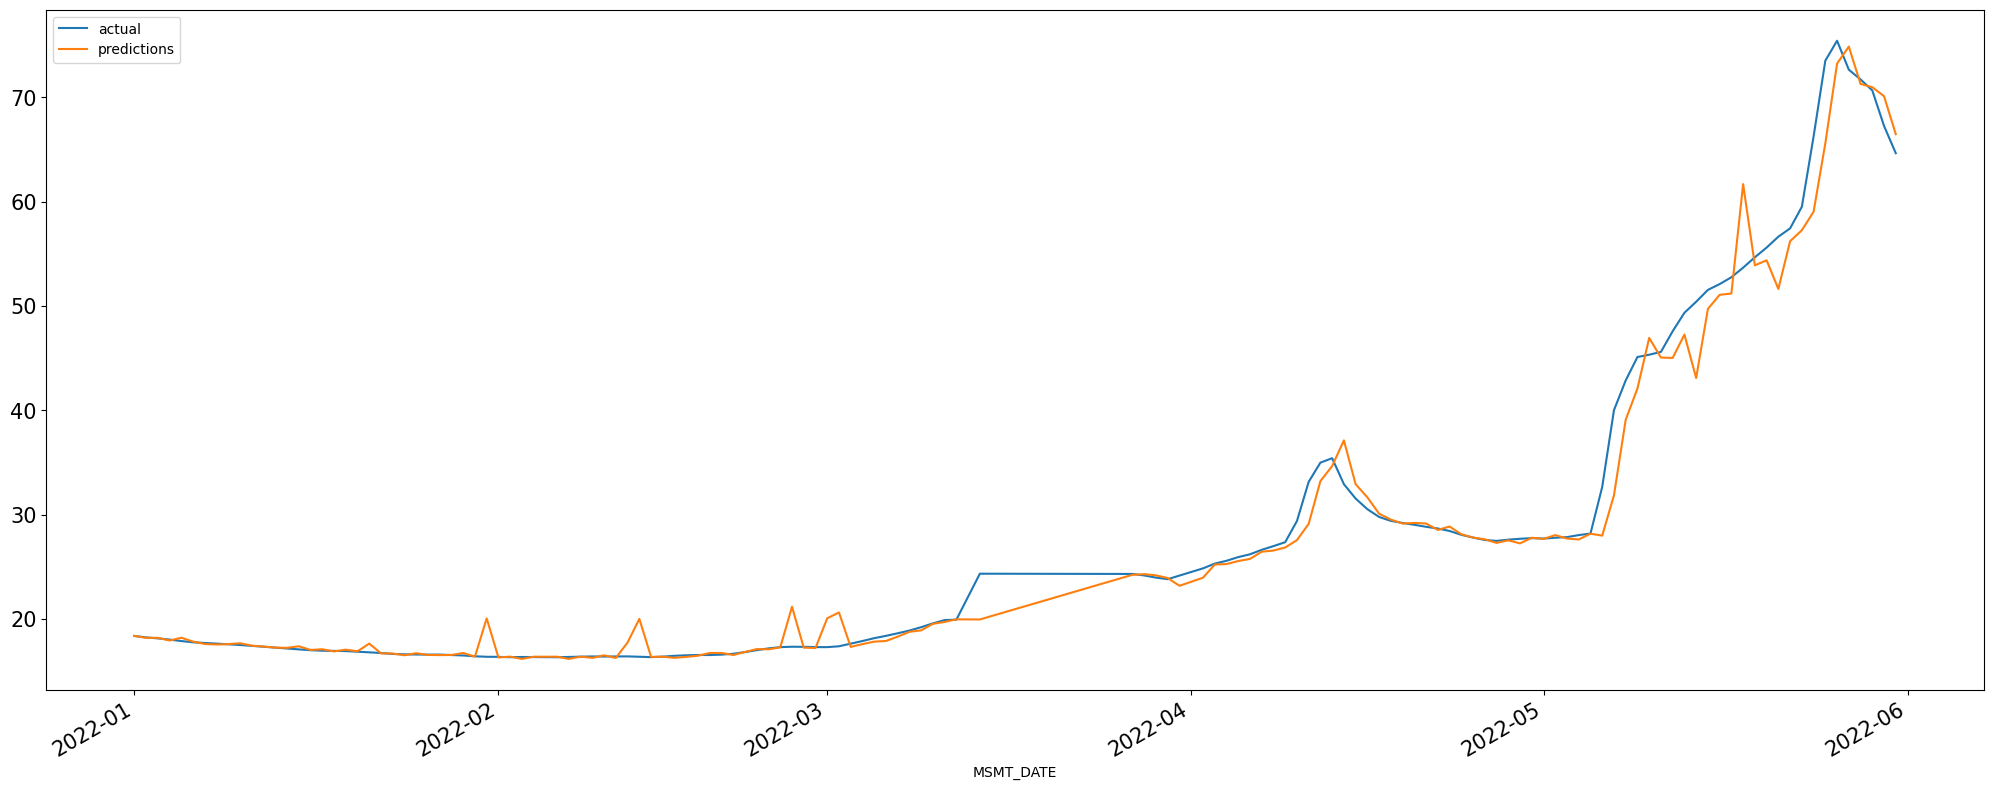

In [ ]:
bagging_reg = ske.BaggingRegressor(n_estimators=10, random_state=0)

predict_linear_regressors(daily_data_by_sample_station, bagging_reg)

## Random forest regressor.

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

Explained variance regression score: 0.909
Maximum residual error: 16.496
Mean squared error: 22.331
Coeficcient of determination: 0.905
Root-mean-square deviation: 4.726


,actual,predictions
MSMT_DATE,,
2022-01-01,18.382,14.761855
2022-01-02,18.244,14.761855
2022-01-03,18.151,14.761855
2022-01-04,18.032,14.761855
2022-01-05,17.894,14.761855
...,...,...
2022-05-27,72.663,89.159050
2022-05-28,71.726,58.990728
2022-05-29,70.673,58.019113


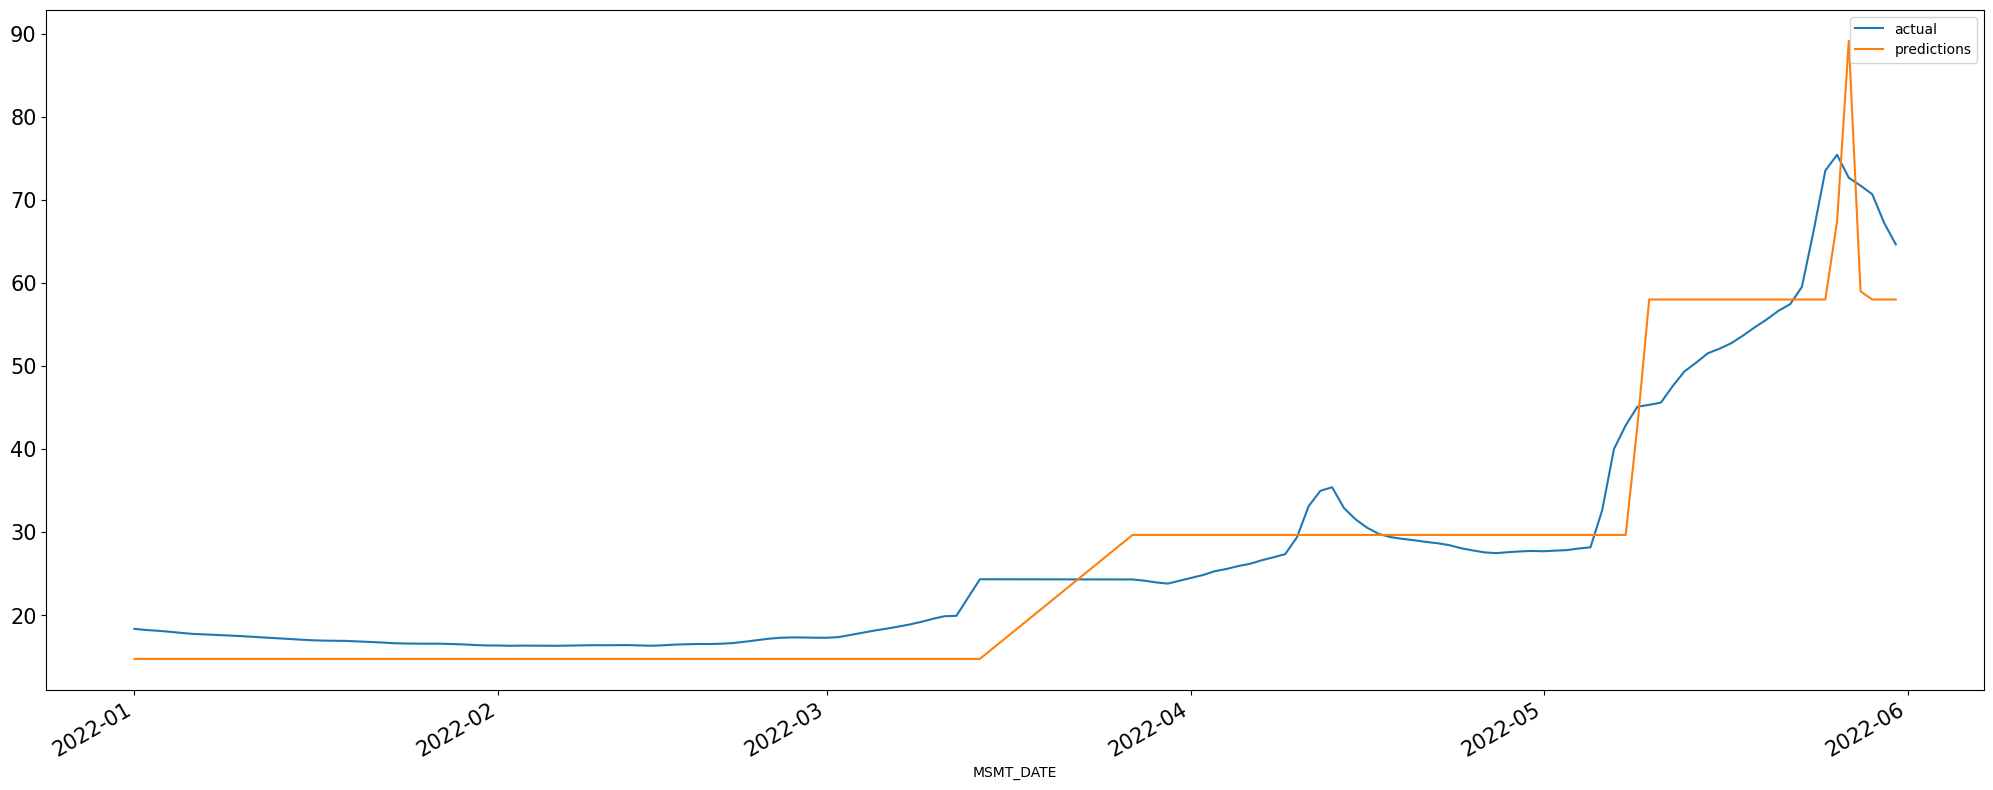

In [ ]:
random_forest_reg = ske.RandomForestRegressor(max_depth=2, random_state=0)
predict_linear_regressors(daily_data_by_sample_station, random_forest_reg)

# Tree-based Models
## Decision Tree regressor

Explained variance regression score: 0.974
Maximum residual error: 11.973
Mean squared error: 6.171
Coeficcient of determination: 0.974
Root-mean-square deviation: 2.484


,actual,predictions
MSMT_DATE,,
2022-01-01,18.382,18.342
2022-01-02,18.244,18.361
2022-01-03,18.151,18.100
2022-01-04,18.032,17.931
2022-01-05,17.894,18.275
...,...,...
2022-05-27,72.663,74.906
2022-05-28,71.726,72.057
2022-05-29,70.673,71.205


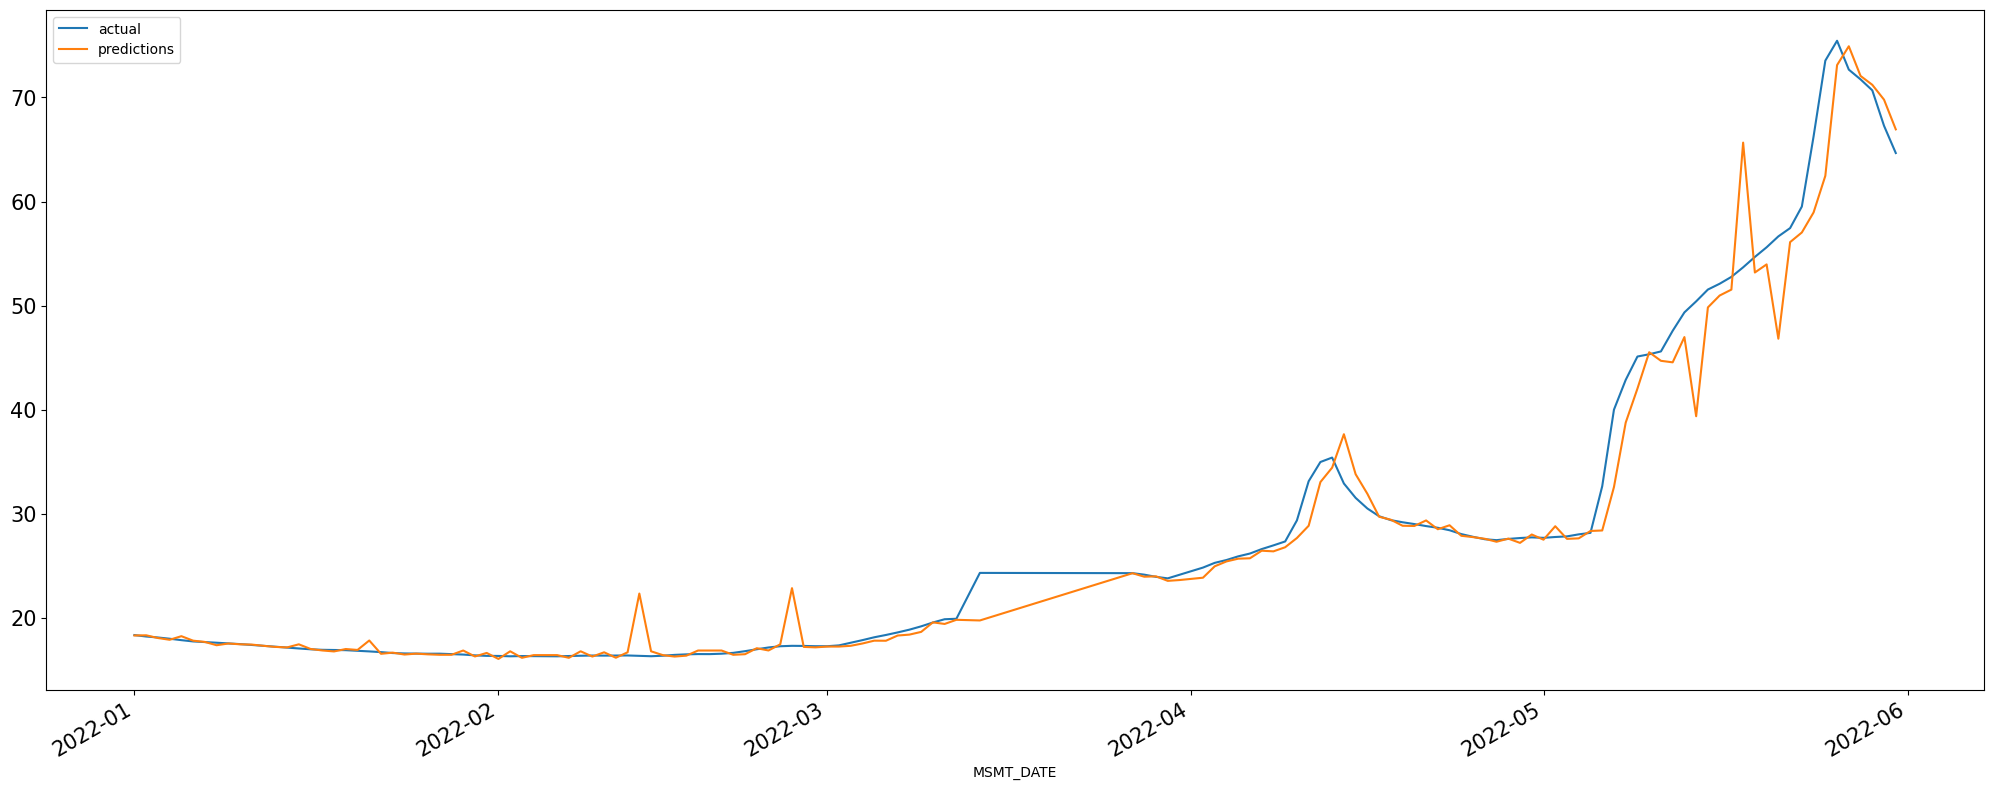

In [ ]:
decision_tree_reg = skt.DecisionTreeRegressor(random_state=0)

predict_linear_regressors(daily_data_by_sample_station, decision_tree_reg)

## Gradient Boosting for regression.
This estimator builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

sklearn.ensemble.HistGradientBoostingRegressor is a much faster variant of this algorithm for intermediate datasets (n_samples >= 10_000).

Explained variance regression score: 0.990
Maximum residual error: 8.160
Mean squared error: 2.588
Coeficcient of determination: 0.989
Root-mean-square deviation: 1.609


,actual,predictions
MSMT_DATE,,
2022-01-01,18.382,18.226754
2022-01-02,18.244,18.226754
2022-01-03,18.151,18.226754
2022-01-04,18.032,18.226754
2022-01-05,17.894,18.226754
...,...,...
2022-05-27,72.663,74.777094
2022-05-28,71.726,71.501686
2022-05-29,70.673,71.331983


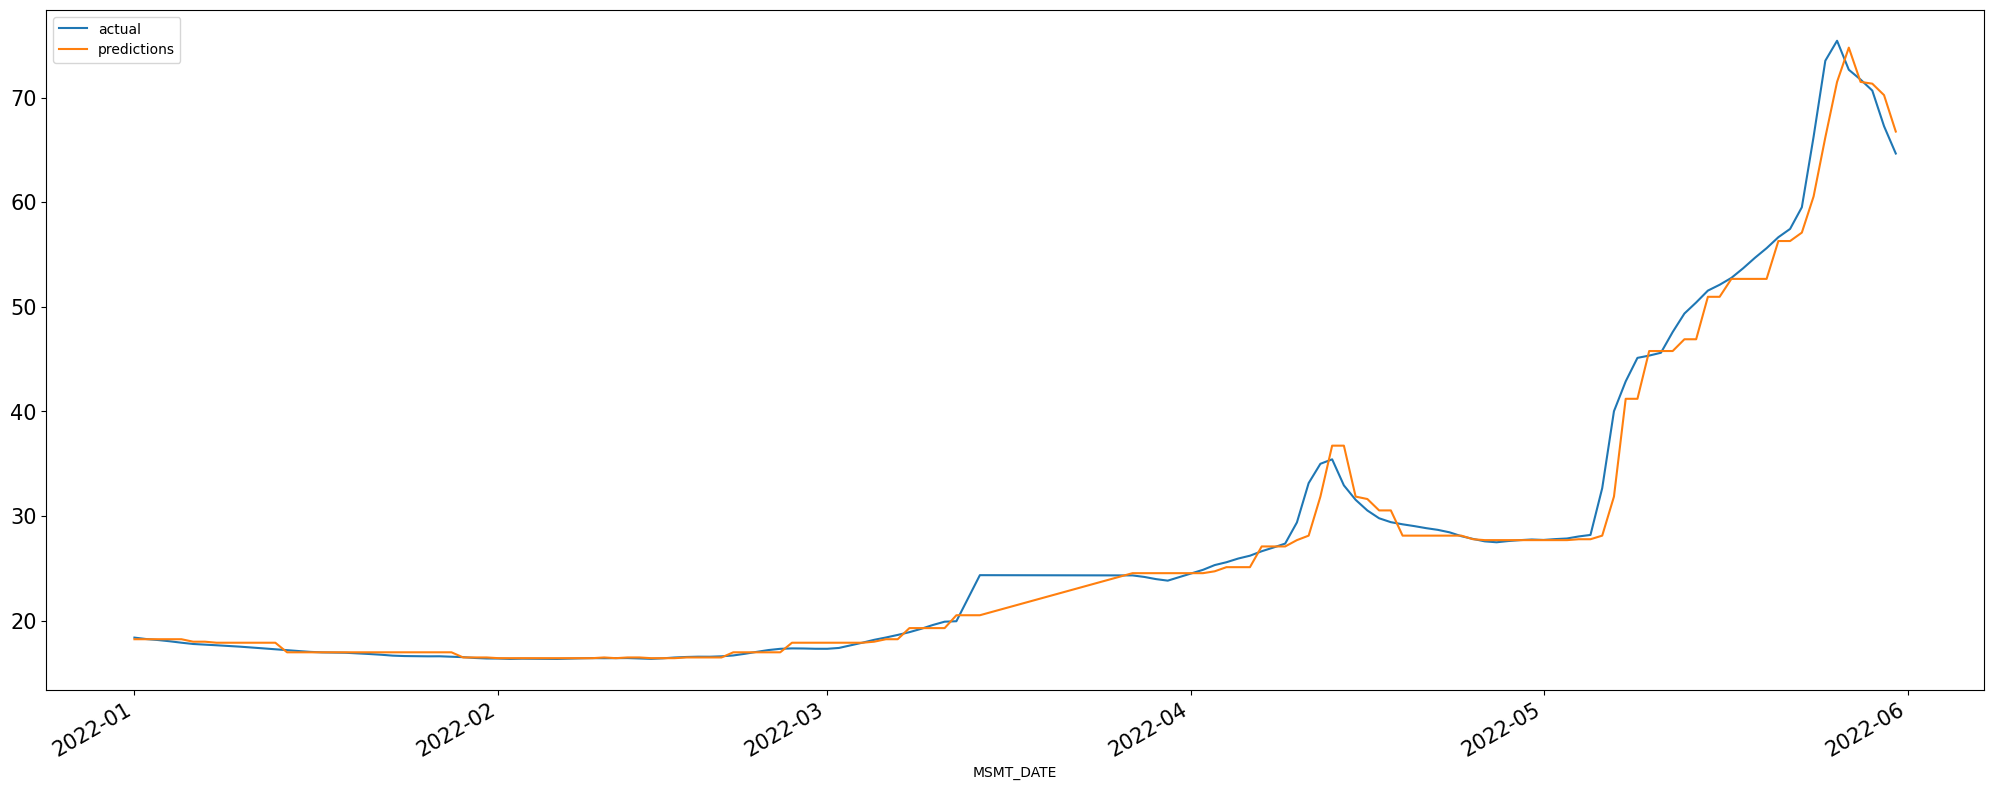

In [ ]:
gradient_boosting_reg = ske.GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='squared_error')

predict_linear_regressors(daily_data_by_sample_station, gradient_boosting_reg)

## RNN
Recurrent Neural Networks

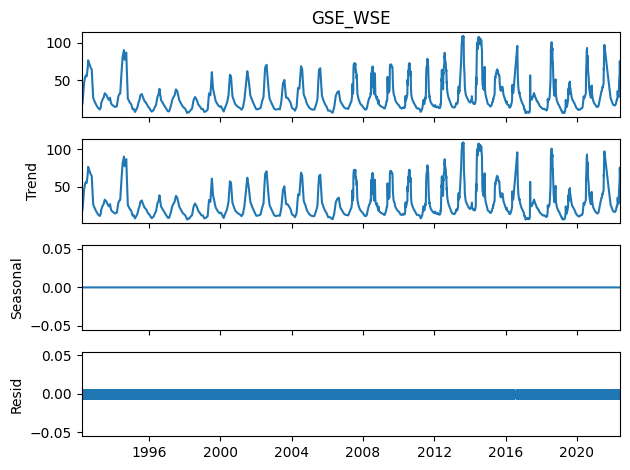

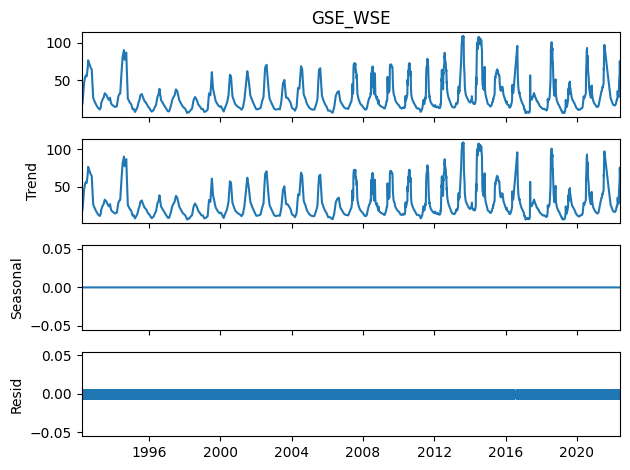

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(daily_data_by_sample_station["GSE_WSE"], model='additive', extrapolate_trend='freq', period=1)
results.plot()

# Multivariate LSTM Forecast Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import seaborn as sns
from math import sqrt

## Preprocess series data to be consumed by model implementing supervised learning
1. Create predictor variable columns (X values)
2. Create variables to be predicted columns (y values)
3. Concatenate columns.
4. Drop columns that contain "not a number" values.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]


    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

## Predict recurrent neural network function
1. Predict y value(s) by using x values (test)
2. Invert scale for forecast (if scaled was used)
3. Invert scale for predictor (if scaled was used)
4. Concatenate predictions vs real results in a new data frame
5. Plot and print model performance.

In [ ]:
def predict_recurrent_neural_network(test_ndarrays: List[np.ndarray], model, scaler: skpp=None) -> pd.DataFrame:
    test_X, test_y = test_ndarrays[2], test_ndarrays[3]

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    if scaler is not None:
        inv_yhat = scaler.inverse_transform(inv_yhat)
        print(f'inversed inv_yhat with scale {type(scaler)}')
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    if scaler is not None:
        inv_y = scaler.inverse_transform(inv_y)
        print(f'inversed inv_y with scale {type(scaler)}')
    inv_y = inv_y[:,0]

    if scaler is None:
        combined: pd.DataFrame = pd.concat([test.iloc[:-1]["target"], pd.Series(inv_yhat, index=test.iloc[:-1].index)], axis=1)
    else:
        combined: pd.DataFrame = pd.concat([pd.Series(inv_y), pd.Series(inv_yhat)], axis=1)
    combined.columns = ["actual", "predictions"]

    model_metrics(combined["actual"], combined["predictions"])
    combined.plot(figsize=(25,10), fontsize=15)

    return combined

## Pre process dataset function
1. Create train and test dataframes based on provided dataframe
2. Encode labels (optional)
3. Cast values to float32 (optional)
4. Normalize features with scaler (optional)
5. Pre-process data and arrange in the model's supervised learning configuration (using series_to_supervised function)
6. Re-shape data to the model's required configuration

In [ ]:
def pre_process_datasets(dataframe: pd.DataFrame,
                         predictors: List[str]=["WLM_RPE", "WLM_GSE", "RPE_WSE", "GSE_WSE", "WSE"],
                         scaler: skpp=None,
                         encode_labels: bool=False,
                         cast_float32: bool=False) -> []:
    dataframes: List[pd.DataFrame] = dataframe_training_testing_subsets(dataframe)
    train: pd.DataFrame = dataframes[0]
    test: pd.DataFrame = dataframes[1]
    train_values = train[predictors].values
    test_values = test[predictors].values

    # integer encode direction
    if encode_labels:
        encoder = skpp.LabelEncoder()
        train_values[:,3] = encoder.fit_transform(train_values[:,3])
        test_values[:,3] = encoder.fit_transform(test_values[:,3])
        print('encoding labels...')
        print(train_values[:,3])

    # ensure all data is float
    if cast_float32:
        train_values = train_values.astype('float32')
        test_values = test_values.astype('float32')
        print('casting to float32...')
        print(train_values[:5])

    # noremalize features
    if scaler is not None:
        train_values = scaler.fit_transform(train_values)
        test_values = scaler.fit_transform(test_values)
        print(f'fitting and transforming to scale {type(scaler)}...')
        print(train_values[:5])

    # frame as supervised learning
    reframed_train = series_to_supervised(train_values, 1, 1)
    reframed_test = series_to_supervised(test_values, 1, 1)

    # drop columsn we don't want to predict
    reframed_train.drop(reframed_train.columns[[5,6,7,9]], axis=1, inplace=True)
    reframed_test.drop(reframed_test.columns[[5,6,7,9]], axis=1, inplace=True)

    # reshape input to be 3D
    train_X, train_y = reframed_train.values[:, :-1], reframed_train.values[:, -1]
    test_X, test_y = reframed_test.values[:, :-1], reframed_test.values[:, -1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


    res = []
    res.extend([train_X, train_y, test_X, test_y, scaler])
    return res

## Plot history function
Function to print the model's training history data.

In [ ]:
from keras.callbacks import History

def plot_history(history: History) -> None:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

## LSTM model
Using a sequential pipeline create a LSTM model and add layers to it.
1. Train the model
2. Plot its history
3. Create and print predictions

In [ ]:
def predict_recurrent_neural_network(test_ndarrays: List[np.ndarray], model, scaler: skpp=None) -> pd.DataFrame:
    test_X, test_y = test_ndarrays[2], test_ndarrays[3]

    # make a prediction
    yhat = model.predict(test_X)

    # Reshape predictions and actual values if necessary
    yhat = yhat.flatten()
    test_y = test_y.flatten()

    # Ensure predictions have the same length as actual values
    if len(yhat) != len(test_y):
        raise ValueError(f"Prediction length ({len(yhat)}) does not match actual test set length ({len(test_y)})")

    # Inverse scaling for predictions if a scaler is provided
    if scaler is not None:
        yhat = scaler.inverse_transform(yhat.reshape(-1, 1)).flatten()
        test_y = scaler.inverse_transform(test_y.reshape(-1, 1)).flatten()

    # Combine actual and predicted values into a DataFrame
    combined = pd.DataFrame({
        "actual": test_y,
        "predictions": yhat
    })


    combined.plot(figsize=(16, 6), fontsize=15)
    plt.title("Actual vs Predicted")
    plt.show()


    return combined


Pre-process the Datasets

In [ ]:
def predict_lstm_model(dataframe: pd.DataFrame, model, predictors: List[str]=["WLM_RPE", "WLM_GSE", "RPE_WSE", "GSE_WSE", "WSE"], scaler=None) -> pd.DataFrame:
    # Split data into training and testing sets
    dataframes: List[pd.DataFrame] = dataframe_training_testing_subsets(dataframe)
    train: pd.DataFrame = dataframes[0]
    test: pd.DataFrame = dataframes[1]

    # Extract predictors and target
    train_X = train[predictors].values
    test_X = test[predictors].values
    train_y = train["target"].values.reshape(-1, 1)
    test_y = test["target"].values.reshape(-1, 1)

    # Normalize the data if a scaler is provided
    if scaler is not None:
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        train_y = scaler.fit_transform(train_y)
        test_y = scaler.transform(test_y)

    # Reshape data for LSTM (3D input: [samples, timesteps, features])
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Train the LSTM model
    history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

    # Make predictions
    yhat = model.predict(test_X)

    # Ensure predictions have the same length as test_y
    if yhat.shape[0] != test_y.shape[0]:
        raise ValueError(f"Prediction length ({yhat.shape[0]}) does not match test_y length ({test_y.shape[0]})")

    # Flatten the predictions and actual values to 1D
    yhat = yhat.flatten()
    test_y = test_y.flatten()

    # Inverse scaling of predictions if a scaler is provided
    if scaler is not None:
        yhat = scaler.inverse_transform(yhat.reshape(-1, 1)).flatten()
        test_y = scaler.inverse_transform(test_y.reshape(-1, 1)).flatten()

    # Combine actual and predicted values into a DataFrame
    combined: pd.DataFrame = pd.concat([pd.Series(test_y, index=test.index), pd.Series(yhat, index=test.index)], axis=1)
    combined.columns = ["actual", "predictions"]

    # Calculate model metrics (MAE, RMSE, R²)
    model_metrics(test_y, yhat)

    # Plot the results
    combined.plot(figsize=(25, 10), fontsize=15)

    return combined


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


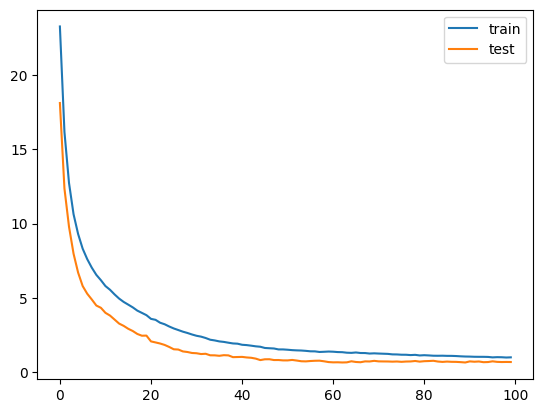

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


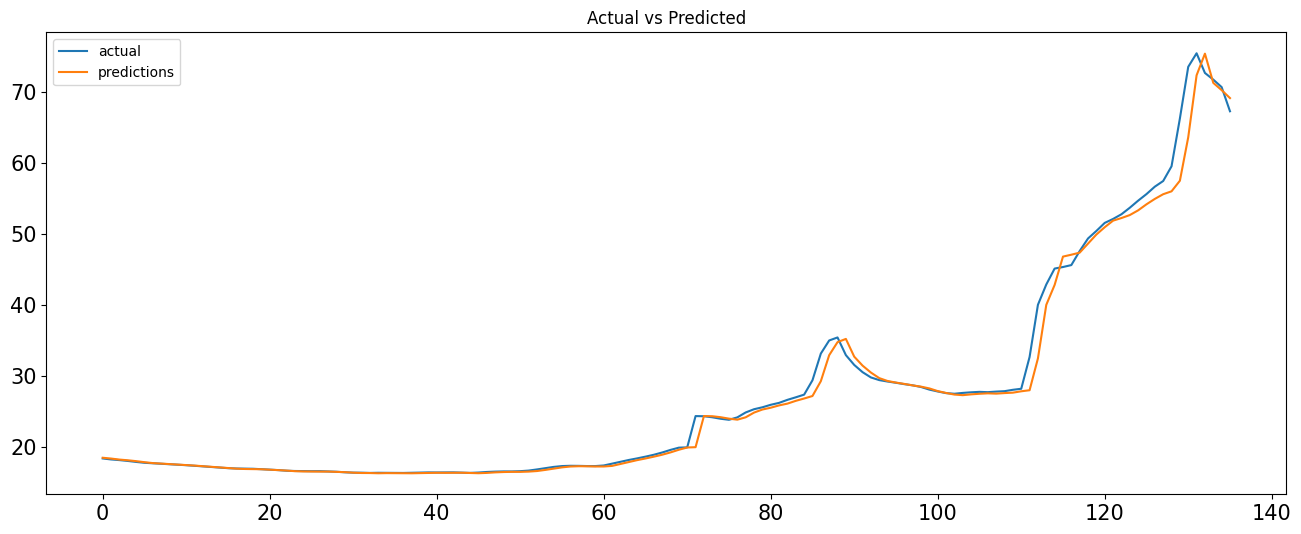

Explained variance regression score: 0.989
Maximum residual error: 9.919
Mean squared error: 2.751
Coeficcient of determination: 0.988
Root-mean-square deviation: 1.659


In [ ]:

from keras.models import Sequential
from keras.layers import LSTM, Dense


train_X, train_y, test_X, test_y, scaler = datasets[0], datasets[1], datasets[2], datasets[3], datasets[4]

# Design LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# Plot training history
plot_history(history)

target = test_y
predictions = model.predict(test_X)
# Make predictions
predict_recurrent_neural_network(datasets, model, scaler)
print("Explained variance regression score: %.3f" %skm.explained_variance_score(target, predictions))
print("Maximum residual error: %.3f" %skm.max_error(target, predictions))
print("Mean squared error: %.3f" %skm.mean_squared_error(target, predictions))
print("Coeficcient of determination: %.3f" %skm.r2_score(target, predictions))
print("Root-mean-square error: %.3f" %sqrt(skm.mean_squared_error(target, predictions)))
